In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score

In [11]:
# Define paths for train and test images
train_dir = '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test'
imbalance_handling_dir = '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'  # Same directory as train_dir for class imbalance handling

In [12]:
# Define image dimensions and batch size
img_width = 180
img_height = 180
batch_size = 32

In [13]:
# Load and preprocess data
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1635 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [14]:
# Define and compile the CNN model
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='softmax'))  # 9 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=1e-7)

In [16]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction])

Epoch 1/20
51/51 [==============================] - 400s 8s/step - loss: 1.1228 - accuracy: 0.5777 - val_loss: 2.7273 - val_accuracy: 0.3229 - lr: 5.0000e-04
Epoch 2/20
51/51 [==============================] - 381s 7s/step - loss: 1.0787 - accuracy: 0.5983 - val_loss: 3.3386 - val_accuracy: 0.2812 - lr: 5.0000e-04
Epoch 3/20
51/51 [==============================] - 388s 8s/step - loss: 1.0712 - accuracy: 0.5951 - val_loss: 3.4103 - val_accuracy: 0.2604 - lr: 5.0000e-04
Epoch 4/20
51/51 [==============================] - 390s 8s/step - loss: 1.0969 - accuracy: 0.5739 - val_loss: 3.6821 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 5/20
51/51 [==============================] - 380s 7s/step - loss: 1.0923 - accuracy: 0.5933 - val_loss: 3.5571 - val_accuracy: 0.3229 - lr: 5.0000e-04
Epoch 6/20
51/51 [==============================] - ETA: 0s - loss: 1.1007 - accuracy: 0.5889
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
51/51 [==============================] -

In [17]:
# Evaluate the model on the test data
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)
accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", accuracy)

# Save the model
model.save('melanoma_detection_model.h5')

4/4 [==============================] - 14s 3s/step
Test Accuracy: 0.1864406779661017


In [18]:
# Data Distribution Analysis
class_names = list(train_generator.class_indices.keys())
class_counts = [train_generator.classes.tolist().count(i) for i in range(len(class_names))]
class_distribution = dict(zip(class_names, class_counts))
print("Class Distribution:", class_distribution)

Class Distribution: {'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 255, 'seborrheic keratosis': 0, 'squamous cell carcinoma': 0, 'vascular lesion': 0}


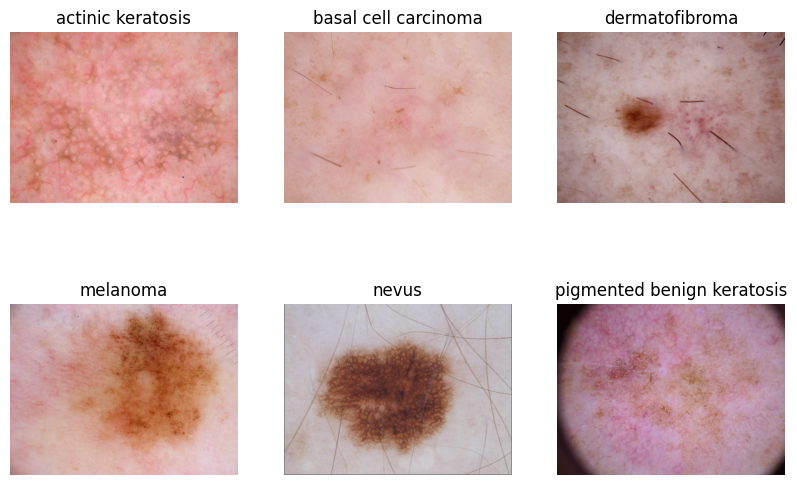

In [19]:
# Dataset Visualization
plt.figure(figsize=(10, 10))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.exists(class_dir) and len(os.listdir(class_dir)) > 0:
        sample_image_path = os.path.join(class_dir, os.listdir(class_dir)[0])
        sample_image = Image.open(sample_image_path)
        plt.subplot(3, 3, i+1)
        plt.imshow(sample_image)
        plt.title(class_name)
        plt.axis('off')
plt.show()

In [20]:
# Model Building & Training (First Iteration) Analysis
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
if train_accuracy > val_accuracy:
    print("Evidence of Overfitting")
elif train_accuracy < val_accuracy:
    print("Evidence of Underfitting")
else:
    print("Balanced Fit")

Train Accuracy: 0.6325639486312866
Validation Accuracy: 0.3229166567325592
Evidence of Overfitting


In [21]:
# Class Distribution Analysis
min_class = min(class_distribution, key=class_distribution.get)
print("Class with Least Samples:", min_class)
max_class = max(class_distribution, key=class_distribution.get)
print("Class with Most Samples:", max_class)

Class with Least Samples: seborrheic keratosis
Class with Most Samples: melanoma


In [22]:
# Class Imbalance Handling
import Augmentor

# Create a pipeline for class imbalance handling
p = Augmentor.Pipeline(imbalance_handling_dir)

# Add augmentation operations to the pipeline
p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
p.random_contrast(probability=0.5, min_factor=0.5, max_factor=1.5)
# Add more augmentation operations as needed

# Generate augmented samples
num_augmented_samples = 5000  # This sample number is adjusted accordingly
p.sample(num_augmented_samples)

Initialised with 1635 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BE84DF8F400>: 100%|██████████| 5000/5000 [12:39<00:00,  6.58 Samples/s]


In [23]:
# Model Building & Training (Third Iteration)
# Rebuild and retrain the model on the rectified class imbalance data
# Use the same architecture and compile the model as before
history_imbalanced = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction])

Epoch 1/30
51/51 [==============================] - 396s 8s/step - loss: 0.9997 - accuracy: 0.6195 - val_loss: 4.4322 - val_accuracy: 0.3438 - lr: 1.2500e-04
Epoch 2/30
51/51 [==============================] - 381s 7s/step - loss: 1.0037 - accuracy: 0.6220 - val_loss: 4.5751 - val_accuracy: 0.2604 - lr: 1.2500e-04
Epoch 3/30
51/51 [==============================] - 386s 8s/step - loss: 0.9720 - accuracy: 0.6294 - val_loss: 4.1777 - val_accuracy: 0.3438 - lr: 1.2500e-04
Epoch 4/30
51/51 [==============================] - 384s 8s/step - loss: 0.9828 - accuracy: 0.6257 - val_loss: 4.1123 - val_accuracy: 0.2812 - lr: 1.2500e-04
Epoch 5/30
51/51 [==============================] - 384s 8s/step - loss: 0.9694 - accuracy: 0.6382 - val_loss: 4.2853 - val_accuracy: 0.3646 - lr: 1.2500e-04
Epoch 6/30
51/51 [==============================] - 385s 7s/step - loss: 0.9653 - accuracy: 0.6494 - val_loss: 4.4719 - val_accuracy: 0.3021 - lr: 1.2500e-04
Epoch 7/30
51/51 [==============================] - 

In [24]:
# Evaluate the model on the test data after handling class imbalance
y_pred_imbalanced = np.argmax(model.predict(test_generator), axis=-1)
accuracy_imbalanced = accuracy_score(y_true, y_pred_imbalanced)
print("Test Accuracy (Imbalanced Handling):", accuracy_imbalanced)

4/4 [==============================] - 14s 3s/step
Test Accuracy (Imbalanced Handling): 0.16101694915254236
